# Combining the processed crop data

In [1]:
import os, json, zipfile
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from tools import get_product_name_dict
import matplotlib.pyplot as plt
from tools import execute_all_notebooks
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 100)

## Execute the crop profiling notebooks

In [2]:
execute_all = True
# Define the country list
country_code_list = [
    'AO',   # Angola
    'BF',   # Burkina Faso
    'BI',   # Burundi
    'BJ',   # Benin
    'CD',   # Congo, The Democratic Republic of the
    'CF',   # Central African Republic
    'CM',   # Cameroon
    'ET',   # Ethiopia
    'GH',   # Ghana
    'GN',   # Guinea
    'KE',   # Kenya
    'LR',   # Liberia
    'LS',   # Lesotho
    'MG',   # Madagascar
    'ML',   # Mali
    'MR',   # Mauritania
    'MW',   # Malawi
    'MZ',   # Mozambique
    'NE',   # Niger
    'NG',   # Nigeria
    'RW',   # Rwanda
    'SDSS', # Sudan and South Sudan
    'SL',   # Sierra Leone
    'SN',   # Senegal
    'SO',   # Somalia
    'TD',   # Chad
    'TG',   # Togo
    'TZ',   # Tanzania
    'UG',   # Uganda
    'ZA',   # South Africa
    'ZM',   # Zambia
    'ZW'    # Zimbabwe
]
country_code_list_raw = country_code_list.copy()
country_to_exclude = []
# Execute all notebooks
if execute_all:
    failed_notebooks, summary = execute_all_notebooks(country_code_list, country_to_exclude)

Executing all notebooks...
Notebooks execution complete.
total_countries: 32
excluded_countries: []
successful_countries: 27
failed_countries: ['BJ', 'ET', 'GN', 'SDSS', 'SO']


## Combine the processed crop data and shapefile

In [3]:
# If "SDSS" is in the country list, replace with "SD" and "SS"
if 'SDSS' in country_code_list:
    country_code_list.remove('SDSS')
    country_code_list.append('SD')
    country_code_list.append('SS')

In [4]:
# Product mapping and selection ============================= #
container = []
for country_code in country_code_list:
    df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_code, index_col=0)
    container.append(df)
df = pd.concat(container, axis=0).reset_index(drop=True)
# Change country name
df['country'] = df['country'].replace({'Congo, The Democratic Republic of the': 'DRC'})
# Check all product names are in the dictionary
product_name_dict = get_product_name_dict()     # Predefined product name mapping
product_diff = set(df['product'].unique()) - set(product_name_dict.values())
if len(product_diff) > 0:
    for p in product_diff:
        country = df[df['product'] == p]['country'].unique()
        print(p, country)
# Select products to remove with rules:
# 1. The product is only produced in a single country.
# 2. The product has less than 200 data points.
cp_count = df[df['indicator'] == 'production'].pivot_table(index='country_code',columns='product', values='value', aggfunc='count').fillna(0).astype(int)
product_single_country = cp_count.columns[(np.sum(cp_count > 0) == 1)]
product_low_data_points = cp_count.columns[cp_count.sum(0) < 200]
product_remove = list(set(product_single_country) & set(product_low_data_points))
cp_remove = cp_count.loc[:, cp_count.columns.isin(product_remove)]
cp_remove = cp_remove[cp_remove.sum(1) > 0]
product_remove_dict = {index: cp_remove.columns[row > 0].tolist() for index, row in cp_remove.iterrows()}
# Manually define products to remove or keep ---------------- #
product_keep = []
product_remove_country = {
    'ET':['Beans (mixed)'],
    'BJ':['Green Pea'],
    'LS':['Barley'], # too low production compared to FAOSTAT
    'MW':['Wheat'], # too many missing units (MPE is -87% compared to FAOSTAT)
}
product_keep_country = {
    'ZA': ['Maize (Yellow)']
}
combined_remove_dict = {}
for country in country_code_list:
    if country not in product_remove_dict:
        products = []
    else:
        products = product_remove_dict[country]
    if country in product_remove_country:
        products += product_remove_country[country]
    if country in product_keep_country:
        products = list(set(products) - set(product_keep_country[country]))
    if len(products) > 0:
        combined_remove_dict[country] = products
# ----------------------------------------------------------- #
num_country = len(combined_remove_dict.keys())
num_product = len(set([p for ps in combined_remove_dict.values() for p in ps]))
print('Total %02d products are selected to remove over %02d countries.' % (num_product, num_country))
for country, products in combined_remove_dict.items():
    print('%s: %s' % (country, ', '.join(products)))
# =========================================================== #

Pyrethrum ['Kenya']
NUA 45 ['Zimbabwe']
Amaranth ['Kenya']
Kale ['Kenya']
Coconut (in shell) ['Kenya']
Black nightshade ['Kenya']
Scallion ['Kenya']
Arrowroot ['Kenya']
Total 52 products are selected to remove over 13 countries.
BI: Cassava (non-bitter), Rice (not husked)
BJ: Colocynth, Green Pea
ET: Beans (Red), Enset, Gibto, Grass Pea, Guava, Safflower Seed, Swiss Chard, Vetch, Beans (mixed)
KE: Amaranth, Arrowroot, Black nightshade, Coconut (in shell), Scallion
LS: Barley
MG: African oil palm nut, Artichoke, Broad Beans, Broccoli, Clove, Cocoa, Fibers, Fodder crop, Other stem vegetables, Pulses (dry), Strawberry, Vanilla
MW: Beans (Pinto), Wheat
MZ: Beans (Lima), Groundnuts (In Shell, Large), Groundnuts (In Shell, Small), Other root/tuber vegetable, Spanish Peanut, Sweet Potatoes (Non-Orange), Sweet Potatoes (Orange)
NE: Anise, Basil, Gourd, Henna, Tigernut
NG: Groundnuts (Without Shell)
RW: Cauliflowers, Champignon, Leeks, Spinach
ZW: NUA 45
SD: Cotton (Egyptian)


In [12]:
# Merge crop data =========================================== #
container = []
for country_code in country_code_list:
    df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_code, index_col=0)
    # Remove the selected products per country
    if country_code in combined_remove_dict.keys():
        df = df.loc[~(np.isin(df['product'],combined_remove_dict[country_code]))]
    # Pivot table
    cols_raw = df.columns
    cols_raw = cols_raw[cols_raw!='QC_flag'] #remove legacy flags
    cols = [
        'fnid', 'country', 'country_code', 'admin_1', 'admin_2', 'name',   
        'season_name', 'planting_year', 'planting_month',
        'harvest_year', 'harvest_month', 'crop_production_system', 
    ]
    area = df[df['indicator'] == 'area'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
    prod = df[df['indicator'] == 'production'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
    crop = prod/area
    area = area.stack().rename('value').reset_index()
    area['indicator'] = 'area'
    prod = prod.stack().rename('value').reset_index()
    prod['indicator'] = 'production'
    crop = crop.stack().rename('value').reset_index()
    crop['indicator'] = 'yield'
    df = pd.concat([area, prod, crop])[cols_raw]
    container.append(df)
df = pd.concat(container, axis=0).reset_index(drop=True)
# Change country name
df['country'] = df['country'].replace({'Congo, The Democratic Republic of the': 'DRC'})
# Pivot table
ind = ['fnid','country','country_code','admin_1','admin_2','product','season_name','planting_year','planting_month','harvest_year','harvest_month','crop_production_system']
pivot = df.pivot_table(index = ind, columns = 'indicator', values='value', aggfunc='count')
assert pivot.max().max() == 1 # checking duplicates
pivot = df.pivot_table(index = ind, columns = 'indicator', values='value').reset_index()
pivot = pivot.sort_values(ind)
pivot.columns.name = None
# Lower case column names
pivot.columns = [col.lower() for col in pivot.columns]
# =========================================================== #

In [13]:
# Merge the shapefiles ====================================== #
path_dir = '../data/shapefile/fewsnet/'
shape_fn_list = []
# Alphabetical order ======================================== #
shape_fn_list.append(os.path.join(path_dir, 'AO_Admin1_2008.shp')) # Angola Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'BF_Admin2_2020.shp')) # Burkina Faso Admin2 in 2020
shape_fn_list.append(os.path.join(path_dir, 'BI_Admin1_1998.shp')) # Brundi Admin1 in 1998
shape_fn_list.append(os.path.join(path_dir, 'BJ_Admin2_2015.shp')) # Benin Admin2 in 2015
shape_fn_list.append(os.path.join(path_dir, 'CD_Admin1_2015.shp')) # DRC Admin1 in 2015
shape_fn_list.append(os.path.join(path_dir, 'CF_Admin1_2003.shp')) # Central African Republic Admin1 in 2003
shape_fn_list.append(os.path.join(path_dir, 'CM_Admin2_2008.shp')) # Cameroon Admin2 in 2008
shape_fn_list.append(os.path.join(path_dir, 'ET_Admin2_2014.shp')) # Ethiopia Admin2 in 2014
shape_fn_list.append(os.path.join(path_dir, 'GH_Admin1_2018.shp')) # Ghana Admin1 in 2018
shape_fn_list.append(os.path.join(path_dir, 'GN_Admin2_1990.shp')) # Guinea Admin2 in 1990
shape_fn_list.append(os.path.join(path_dir, 'KE_Admin1_2013.shp')) # Kenya Admin1 in 2013
shape_fn_list.append(os.path.join(path_dir, 'LR_Admin1_2008.shp')) # Liberia Admin1 in 2008
shape_fn_list.append(os.path.join(path_dir, 'LS_Admin1_1980.shp')) # Lesotho Admin1 in 1980
shape_fn_list.append(os.path.join(path_dir, 'MG_Admin2_2009.shp')) # Madagascar Admin2 in 2009
shape_fn_list.append(os.path.join(path_dir, 'ML_Admin1_2016.shp')) # Mali Admin1 in 2016
shape_fn_list.append(os.path.join(path_dir, 'MR_Admin1_1990.shp')) # Mauritania Admin1 in 1990
shape_fn_list.append(os.path.join(path_dir, 'MW_Admin2_2018.shp')) # Malawi Admin2 in 2018
shape_fn_list.append(os.path.join(path_dir, 'MZ_Admin1_2021.shp')) # Mozambique Admin1 in 2013
shape_fn_list.append(os.path.join(path_dir, 'NE_Admin2_2012.shp')) # Niger Admin2 in 2012
shape_fn_list.append(os.path.join(path_dir, 'NG_Admin1_1996.shp')) # Nigeria Admin1 in 1996
shape_fn_list.append(os.path.join(path_dir, 'RW_Admin2_2006.shp')) # Rwanda Admin2 in 2006
shape_fn_list.append(os.path.join(path_dir, 'SD_Admin1_2013.shp')) # Sudan Admin1 in 2013
shape_fn_list.append(os.path.join(path_dir, 'SL_Admin2_1960.shp')) # Sierra Leone Admin2 in 1960
shape_fn_list.append(os.path.join(path_dir, 'SN_Admin2_2008.shp')) # Senegal Admin2 in 2008
shape_fn_list.append(os.path.join(path_dir, 'SO_Admin2_1990.shp')) # Somalia Admin2 in 1990
shape_fn_list.append(os.path.join(path_dir, 'SS_Admin1_2011.shp')) # South Sudan Admin1 in 2011
shape_fn_list.append(os.path.join(path_dir, 'TD_Admin1_2012.shp')) # Chad Admin1 in 2012
shape_fn_list.append(os.path.join(path_dir, 'TG_Admin2_2009.shp')) # Togo Admin2 in 2009
shape_fn_list.append(os.path.join(path_dir, 'TZ_Admin1_2012.shp')) # Tanzania Admin1 in 2012
shape_fn_list.append(os.path.join(path_dir, 'UG_Admin2_2007.shp')) # Uganda Admin2 in 2007
shape_fn_list.append(os.path.join(path_dir, 'ZA_Admin1_1994.shp')) # South Africa Admin1 in 1994
shape_fn_list.append(os.path.join(path_dir, 'ZM_Admin2_2011.shp')) # Zambia Admin2 in 2011
shape_fn_list.append(os.path.join(path_dir, 'ZW_Admin1_2018.shp')) # Zimbabwe Admin1 in 2018
# =========================================================== #
# Merge the shapefiles
shape = pd.concat([gpd.read_file(fn).to_crs(epsg=4326) for fn in shape_fn_list], axis=0).reset_index(drop=True)
shape['COUNTRY_ISO'] = shape['FNID'].apply(lambda x: x[:2])
shape = shape[['FNID','COUNTRY_ISO','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values('FNID').reset_index(drop=True)
# Check all fnid in the crop data are in the shapefile
fnid_diff = set(pivot['fnid'].unique()) - set(shape['FNID'].unique())
assert len(fnid_diff) == 0
# Manual correction
# Drop a row if FNID is "ZW2011A21503" and ADMIN2 is "Hwange Urban"
shape = shape[~((shape['FNID'] == 'ZW2011A21503') & (shape['ADMIN2'] == 'Hwange Urban'))]
assert len(shape['FNID'].unique()) == shape.shape[0]
# Reduce to designated countries
if True: shape = shape[shape['COUNTRY_ISO'].isin(country_code_list)].reset_index(drop=True)
# Create country boundary (Admin0)
admin0 = shape.copy(deep=True)
admin0['ADMIN_CODE'] = admin0['FNID'].apply(lambda x: x[:8])
admin0 = admin0.to_crs(epsg=3857)
admin0['geometry'] = admin0['geometry'].buffer(200)
admin0 = admin0.dissolve(by='ADMIN_CODE')
admin0['geometry'] = admin0['geometry'].buffer(-200)
admin0 = admin0.loc[~admin0.index.isin(['KE2009A1','SO1990A1','ZW2011A1']),:]
admin0[['ADMIN1','ADMIN2']] = ''
admin0['FNID'] = admin0.index
admin0['FNID'] = admin0['FNID'].apply(lambda x: x[:-1]+'0')
admin0 = admin0.reset_index(drop=True)
admin0 = admin0.to_crs(epsg=4326)
# Merge
shape = pd.concat([admin0, shape], ignore_index=True).reset_index(drop=True)
shape = shape[['FNID','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values(by=['FNID']).reset_index(drop=True)
# Drop duplicates
shape = shape.drop_duplicates(subset=['FNID'], keep='first').reset_index(drop=True)
# Change country_name
shape['ADMIN0'] = shape['ADMIN0'].replace({'Democratic Republic of the Congo': 'DRC'})
# =========================================================== #

In [14]:
# Save the data (All-purpose) =============================== #
fn_out = '../public/hvstat_data.csv'
pivot.to_csv(fn_out, index=False)
print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
# Simplify the shapefile
shape_simplified = shape.copy()
shape_simplified.geometry = shape_simplified.geometry.simplify(0.001)
fn_out = '../public/hvstat_boundary.gpkg'
shape_simplified.to_file(fn_out, driver='GPKG')
print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
# =========================================================== #

# Save the data (Official version) ========================== #
if True:
    # Version number
    version = '1.0'
    fn_out = f'../public/hvstat_africa_data_v{version}.csv'
    pivot.to_csv(fn_out, index=False)
    print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
    fn_out = f'../public/hvstat_africa_boundary_v{version}.gpkg'
    # Select boundaries only shown in the data
    admin_level = pivot['fnid'].apply(lambda x: x[:8]).unique()
    shape_simplified = shape_simplified[shape_simplified['FNID'].apply(lambda x: x[:8]).isin(admin_level)].reset_index(drop=True)
    shape_simplified.to_file(fn_out, driver='GPKG')
    print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
    # Create a zipped file of the raw crop data files of all countries.
    file_list = []
    for country_code in country_code_list_raw:
        fn_data_raw = f'../data/crop_raw_data/adm_crop_data_raw_{country_code}.csv'
        if os.path.exists(fn_data_raw):
            file_list.append(fn_data_raw)
    fn_out = f'../public/fdw_raw_data_v{version}.zip'
    with zipfile.ZipFile(fn_out, 'w', compression=zipfile.ZIP_DEFLATED, compresslevel=9) as zf:
        for fn in file_list:
            zf.write(fn, arcname=os.path.basename(fn))
    print('%s is saved (%.2f MB).' % (fn_out, os.path.getsize(fn_out)/1024**2))
# =========================================================== #

../public/hvstat_data.csv is saved (21.85 MB).
../public/hvstat_boundary.gpkg is saved (10.78 MB).
../public/hvstat_africa_data_v1.0.csv is saved (21.85 MB).
../public/hvstat_africa_boundary_v1.0.gpkg is saved (7.82 MB).
../public/fdw_raw_data_v1.0.zip is saved (38.09 MB).


## Map of processed countries

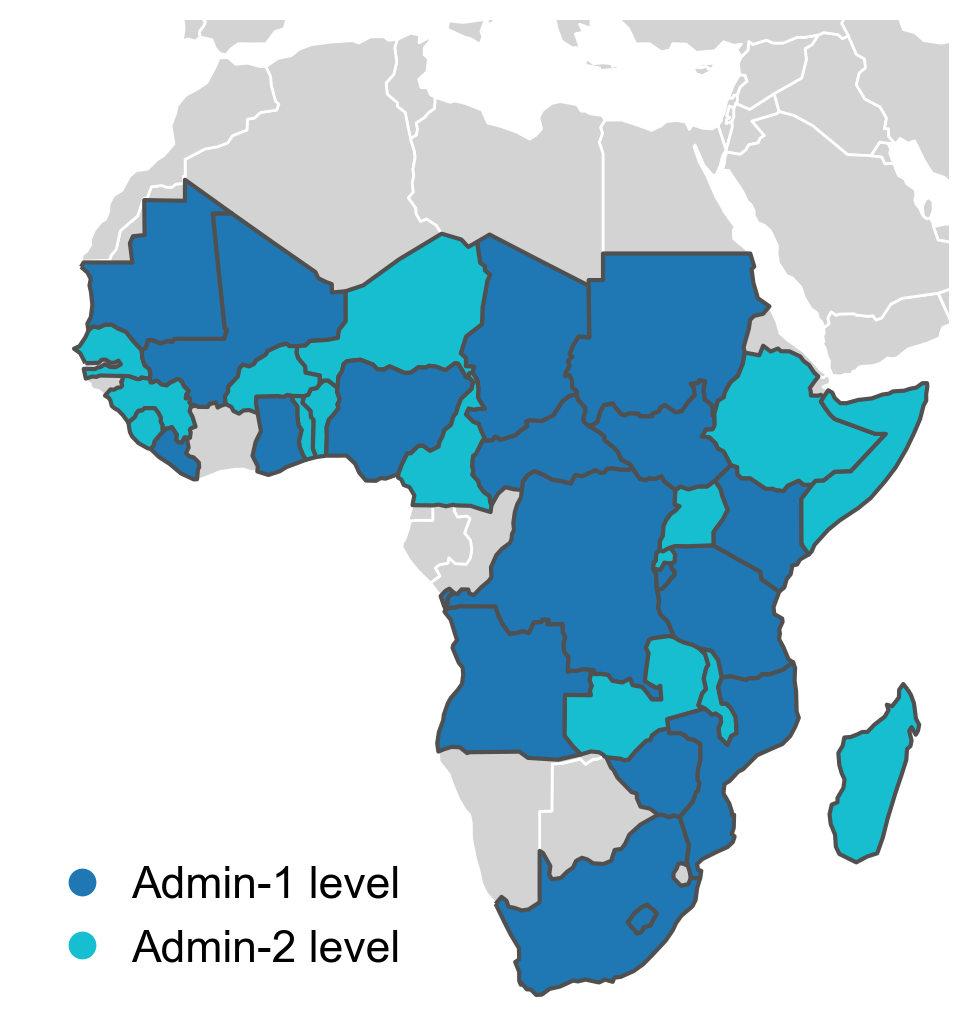

In [15]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['font.sans-serif'] = 'Arial'

# Little touch on world boundary ---------------------------- #
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
world = world.rename(columns={'ADMIN':'name'})
somalia = world[world['name'].isin(['Somalia', 'Somaliland'])].dissolve()
world = pd.concat([world[~world['name'].isin(['Somalia', 'Somaliland'])], somalia], axis=0)
world.replace(
    {   'United Republic of Tanzania':'Tanzania, United Republic of',
        'Democratic Republic of the Congo':'DRC',
        'Central African Rep.': 'Central African Republic',
        'S. Sudan':'South Sudan',
    }, inplace=True
)
df = pd.read_csv('../public/hvstat_data.csv')
# ----------------------------------------------------------- #
df['admin'] = df['fnid'].apply(lambda x: x[7])
country_processed = df[['country','admin']].drop_duplicates()
map_processed = world.merge(country_processed, left_on='name', right_on='country', how='inner')
assert len(map_processed['country'].dropna().unique()) == len(df['country'].unique())
map_processed['admin'] = map_processed['admin'].replace({'1':'Admin-1 level', '2':'Admin-2 level'})
# Map of administrative level (African domain)
mapdata = map_processed.copy().to_crs('epsg:3857')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.25, 5), facecolor="white")
ax.set_axis_off()
ax.set_aspect("equal")
ax.axis([-2087412, 5889989, -4274166, 4605999])
world.to_crs("epsg:3857").plot(ax=ax, color="lightgrey", linewidth=1, edgecolor="white")
mapdata.plot(
    ax=ax,
    column="admin",
    linewidth=1.5,
    edgecolor="#505050",
    zorder=2,
    categorical=True,
    legend=True,
    legend_kwds={
        "loc": "lower left",
        "bbox_to_anchor": (-0.07, 0.0),
        "frameon": False,
        "fontsize": 16,
        "handletextpad": 0.1
    },
)
# Figure frame outline
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")
plt.tight_layout()
plt.subplots_adjust(left=0.0, right=0.99, top=0.99, bottom=0.00)
plt.show()
fig.savefig('../docs/current_status_map.png', dpi=300, bbox_inches='tight')

In [16]:
country_processed.groupby('admin')['country'].count()
# Group by admin level, and aggregate texts of each country. When grouping, sort countries by alphabet order.
country_list = country_processed.sort_values('country')
country_list = country_list.groupby('admin')['country'].apply(lambda x: ', '.join(x)).reset_index()
for i, row in country_list.iterrows():
    print('Admin', row['admin'], ':', sum(country_processed['admin'] == row['admin']), 'countries')
    print(row['country'])
    print('')

Admin 1 : 18 countries
Angola, Burundi, Central African Republic, Chad, DRC, Ghana, Kenya, Lesotho, Liberia, Mali, Mauritania, Mozambique, Nigeria, South Africa, South Sudan, Sudan, Tanzania, United Republic of, Zimbabwe

Admin 2 : 15 countries
Benin, Burkina Faso, Cameroon, Ethiopia, Guinea, Madagascar, Malawi, Niger, Rwanda, Senegal, Sierra Leone, Somalia, Togo, Uganda, Zambia

